# Statistical Thinking in Python Part II.

### Acknowledgement
<a id='https://app.datacamp.com/learn/courses/statistical-thinking-in-python-part-2'>DataCamp</a>

### Table of Contents

## Parameter Estimation by Optimization

Datasets in Usage
- `ml_nohitters.csv`
- `female_literacy_fertility.csv`

### Example 1: 
### Q1. How often do we get no-hitters?

The number of games played between each no-hitter in the modern era (1901-2015) of Major League Baseball is stored in the array nohitter_times.

If we assume that no-hitters are described as a **Poisson process**, then the time between no-hitters is **Exponentially** distributed. As we have seen, the ___Exponential distribution___ has a single parameter, which we will call $\tau$, the typical interval time. The value of the parameter  that makes the exponential distribution best match the data is the mean interval time (where time is in units of *number of games*) between no-hitters.

In the following, we will

- Compute the mean time (in units of number of games) between no-hitters.
- Draw 100,000 samples from an Exponential distribution with the parameter we computed from the mean of the inter-no-hitter times.
- Plot the theoretical PDF using plt.hist() and see whether our obsevations match with the theoretical curve or not.

In [1]:
from embedded_data import nohitter_times
from calc_helper import ecdf

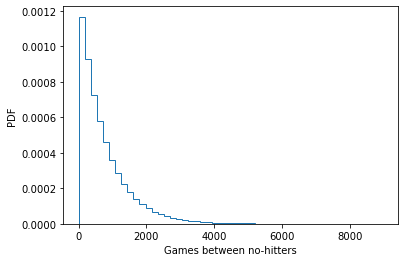

In [2]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100_000)

# Plot the PDF and label axes
plt.figure()
_ = plt.hist(inter_nohitter_time,
             bins=50, 
             density=True, 
             histtype='step')

_ = plt.xlabel('Games between no-hitters')
_ = plt.ylabel('PDF')



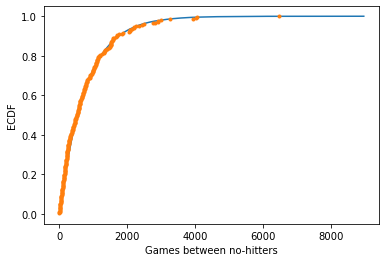

In [3]:
# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

# Create a CDF from observational samples: x, y
x, y = ecdf(nohitter_times)

# CDF curve for theoretical calcs
plt.plot(x_theor, y_theor)

# CDF scatters for observations
plt.plot(x, y, marker='.', linestyle='none')

# Adjust general properties
plt.xlabel('Games between no-hitters')
plt.ylabel('ECDF');

___Comment:___ It looks like no-hitters in the modern era of Major League Baseball are Exponentially distributed. Based on the story of the Exponential distribution, this suggests that they are a random process; when a no-hitter will happen is independent of when the last no-hitter was.

### Q2. How is this parameter optimal?

Now sample out of an exponential distribution with $\tau$ being **twice as large** as the optimal $\tau$. Do it again for $\tau$ **half as large**. Make CDFs of these samples and overlay them with your data. You can see that they do not reproduce the data as well. Thus, the $\tau$ you computed from the mean inter-no-hitter times is optimal in that it best reproduces the data.

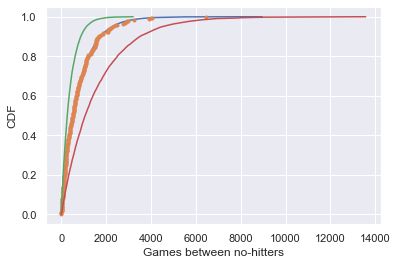

In [4]:
# Plot the theoretical CDFs
sns.set()
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.05)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')

# Take samples with half tau: samples_half
samples_half = np.random.exponential(tau/2, 10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(tau*2, 10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
_ = plt.plot(x_half, y_half)
_ = plt.plot(x_double, y_double)

# Show the plot
plt.show()

### Example 2: Female Illiteracy and Fertility

Next, we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the illiteracy rate.

It is always a good idea to do some EDA ahead of our analysis. To this end, plot the fertility versus illiteracy and compute the Pearson correlation coefficient. The NumPy array `illiteracy` has the illiteracy rate among females for most of the world's nations. The array `fertility` has the corresponding fertility data.

In [21]:
from embedded_data import illiteracy, fertility
from calc_helper import ecdf, pearson_r
from viz_helper import print_eq

0.8041324026815341


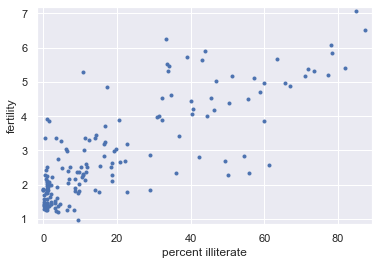

In [6]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

___Comment:___ We can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8. It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman.

slope = 0.04979854809063423 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman

    fertility = 0.0498*illiteracy + 1.8881
    


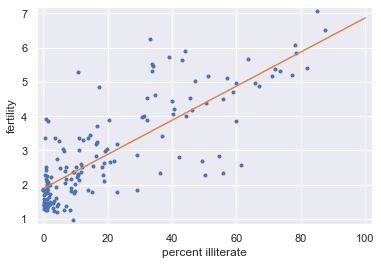

In [22]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
slope, intercept = np.polyfit(illiteracy, fertility, deg=1)

# Print the results to the screen
print('slope =', slope, 'children per woman / percent illiterate')
print('intercept =', intercept, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = slope * x + intercept

# Add regression line to your plot
_ = plt.plot(x, y)

# Output equation
print_eq(slope, intercept, 'illiteracy', 'fertility')

### How is it optimal?

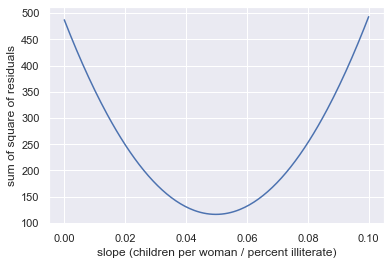

In [14]:
# Specify slopes to consider: a_vals
slope_vals = np.linspace(0, .1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(slope_vals)

# Compute sum of square of residuals for each value of a_vals
for i, slope_val in enumerate(slope_vals):
    rss[i] = np.sum((fertility - slope_val*illiteracy - intercept)**2)
    
# Plot the RSS
plt.plot(slope_vals, rss)
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals');

In [13]:
opt_slope = slope_vals[np.argmin(rss)]
print("Optimal slope: {:.4f}".format(opt_slope))

Optimal slope: 0.0497
